In [1]:
%matplotlib inline
#Imports
from qiskit import QuantumCircuit, execute, Aer, IBMQ, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile, assemble
import numpy as np
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import json
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.tools.monitor import job_monitor

In [2]:
def block_idx(x, y):
    if x<2 and y<2:
        return 0
    if x<2:
        return 1
    if y<2:
        return 2
    return 3

def apply_cands(matrix):
    cands = []
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] != 0:
                continue
            temp = []
            for k in range(4):
                f = True
                for row in range(4):
                    if matrix[row][j] == k + 1:
                        f = False
                for col in range(4):
                    if matrix[i][col] == k + 1:
                        f = False
                for x in range(4):
                    for y in range(4):
                        if block_idx(i, j) != block_idx(x, y):
                            continue
                        if matrix[x][y] == k + 1:
                            f = False
                if f:
                    temp.append(k+1)
            cands.append(temp)
    return cands

In [3]:
def one_cand_op(qc, q0, q1, cands):
    #print(q0, q1)
    if cands[0] == 1:
        pass
    elif cands[0] == 2:
        qc.x(q1)
    elif cands[0] == 3:
        qc.x(q0)
    else:
        qc.x(q0)
        qc.x(q1)

def one_cand_op_inverse(qc, q0, q1, cands): 
    if cands[0] == 1:
        pass
    elif cands[0] == 2:
        qc.x(q1)
    elif cands[0] == 3:
        qc.x(q0)
    else:
        qc.x(q1)
        qc.x(q0)        

In [4]:
def two_cand_op(qc, q0, q1, cands):
    #print(q0, q1, cands[0], cands[1])
    product = cands[0]*cands[1]
    #1 + 2
    if product == 2:
        qc.h(q1)
    #1 + 3
    elif product == 3:
        qc.h(q0)
    #1 + 4
    elif product == 4:
        qc.h(q0)
        qc.cx(q0, q1)
    #2 + 3
    elif product == 6:
        qc.x(q1)
        qc.h(q0)
        qc.cx(q0, q1)
    #2 + 4
    elif product == 8:
        qc.x(q1)
        qc.h(q0)
    #3 + 4
    else:
        qc.h(q1)
        qc.x(q0)
    
def two_cand_op_inverse(qc, q0, q1, cands):
    product = cands[0]*cands[1]
    #1 + 2
    if product == 2:
        qc.h(q1)
    #1 + 3
    elif product == 3:
        qc.h(q0)
    #1 + 4
    elif product == 4:
        qc.cx(q0, q1)
        qc.h(q0)
    #2 + 3
    elif product == 6:
        qc.cx(q0, q1)
        qc.h(q0)
        qc.x(q1)
    #2 + 4
    elif product == 8:
        qc.h(q0)
        qc.x(q1)
    #3 + 4
    else:
        qc.h(q1)
        qc.x(q0)

In [5]:
def init_blanks(qc, qr, matrix):
    cands = apply_cands(matrix)
    # print(cands)

    for i in range(len(cands)):
        if len(cands[i]) == 1:
            one_cand_op(qc, qr[2*i], qr[2*i+1], cands[i])
        else:
            two_cand_op(qc, qr[2*i], qr[2*i+1], cands[i])

def init_blanks_inverse(qc, qr, matrix):
    cands = apply_cands(matrix)
    
    for i in range(len(cands)-1, -1, -1):
        if len(cands[i]) == 1:
            one_cand_op_inverse(qc, qr[2*i], qr[2*i+1], cands[i])
        else:
            two_cand_op_inverse(qc, qr[2*i], qr[2*i+1], cands[i])

In [6]:
# if v1 != v2 (number) then target = 1 else target = 0
def compare_vertex(qc, qr, v1, v2, target):
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])
    qc.x(qr[target])

def compare_vertex_inverse(qc, qr, v1, v2, target):
    qc.x(qr[target])
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])

In [7]:
# Edge constraint oracle
def oracle(qc, qr):
    # vs = [0, 1, 2, 3, 4, 5, 6, 7]
    list1 = [[0, 1], [2, 3], [4, 5], [6, 7], [2, 6], [0, 4]]
    list2 = [[1, 5], [3, 7], [0, 2], [1, 3], [4, 6], [5, 7]]
    target = 16
    temp1 = 30
    temp2 = 31
    for elm in list1:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[temp1], qr[22:29], mode='basic')
    for elm in (reversed(list1)):
        target-=1
        compare_vertex_inverse(qc, qr, elm[0], elm[1], target)
        
    for elm in list2:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[temp2], qr[22:29], mode='basic')
    for elm in (reversed(list2)):
        target-=1
        compare_vertex_inverse(qc, qr, elm[0], elm[1], target)

    dest = 29
    qc.ccx(qr[temp1], qr[temp2], qr[dest])
    
    for elm in list2:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[temp2], qr[22:29], mode='basic')
    for elm in (reversed(list2)):
        target-=1
        compare_vertex_inverse(qc, qr, elm[0], elm[1], target)
        
    for elm in list1:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[temp1], qr[22:29], mode='basic')
    for elm in (reversed(list1)):
        target-=1
        compare_vertex_inverse(qc, qr, elm[0], elm[1], target)

""" diffusion (inversion about the mean) circuit. """
def diffusion(circuit, qr, matrix):
    # circuit.h(qr)
    init_blanks_inverse(circuit, qr[:16], matrix)  # inverse of unitary op of initial state preparation
    circuit.x(qr[:16])

    # apply multi-control CZ
    circuit.h(qr[15])
    # circuit.mct(qr[:-1], qr[-1], anc, mode='basic')
    circuit.mct(qr[:15], qr[15], qr[16:29], mode='basic') 
    circuit.h(qr[15])

    circuit.x(qr[:16])
    # circuit.h(qr)
    init_blanks(circuit, qr[:16], matrix)

In [8]:
qr = QuantumRegister(32)
cr = ClassicalRegister(16)
qc = QuantumCircuit(qr, cr)
matrix = np.array([4, 0, 2, 0, 0, 1, 0, 4, 1, 0, 4, 0, 0, 4, 0, 2]).reshape(4, 4)
print(matrix)
print(apply_cands(matrix))

def grover(iter):
    init_blanks(qc, qr, matrix)
    for _ in range(iter):
        oracle(qc, qr)
        print("oracle done")
        diffusion(qc, qr, matrix)
        print("diffusion done")
    qc.measure(qr[0:16], cr[0:16])
    print("measure done")
    #print("drawing start")
    #qc.draw()

[[4 0 2 0]
 [0 1 0 4]
 [1 0 4 0]
 [0 4 0 2]]
[[3], [1, 3], [2, 3], [3], [2, 3], [3], [3], [1, 3]]


In [9]:
grover(3)

# Unroll the circuit
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 

# obtain gates
gates=new_circuit.count_ops()
print(gates)

cost=gates['u3'] + 10*gates['cx']
print(cost)

oracle done
diffusion done
oracle done
diffusion done
oracle done
diffusion done
measure done
OrderedDict([('u3', 7282), ('cx', 4100), ('measure', 16)])
48282


In [10]:
# shots = 8000
shots = 1024
print("shots:", shots)

## Run on Aer Simulator
backend = Aer.get_backend('qasm_simulator')
## Run on Quantum Hardware(does not techically work however since we need 32 qbits but free only give 7)
## Can run the 2x2 to show that the Sudoku solving does work on a Quantum Computer however
#provider = IBMQ.load_account()
#backend = provider.get_backend('ibm_oslo')

print("execute start")
job = execute(qc, backend=backend, shots=shots, seed_simulator=12345, backend_options={"fusion_enable":True})
print("job id:", job.job_id())
job_monitor(job)
result = job.result()
count = result.get_counts()
print(count)

shots: 1024
execute start
job id: 25410bbc-6f60-46b0-a13a-0c303bbf0d38
Job Status: job has successfully run
{'0001011001100001': 545, '0001011001010001': 40, '0001011001010101': 34, '0101010101100101': 29, '0001010101100001': 42, '0101010101010001': 30, '0101010101010101': 29, '0001010101010001': 33, '0001011001100101': 15, '0101010101100001': 22, '0001010101100101': 44, '0101011001010101': 33, '0101011001100001': 29, '0101011001100101': 37, '0001010101010101': 33, '0101011001010001': 29}


In [11]:
print(len(count))

16


In [12]:
score_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)
final_score = score_sorted[0:15]
final_score

[('0001011001100001', 545),
 ('0001010101100101', 44),
 ('0001010101100001', 42),
 ('0001011001010001', 40),
 ('0101011001100101', 37),
 ('0001011001010101', 34),
 ('0001010101010001', 33),
 ('0101011001010101', 33),
 ('0001010101010101', 33),
 ('0101010101010001', 30),
 ('0101010101100101', 29),
 ('0101010101010101', 29),
 ('0101011001100001', 29),
 ('0101011001010001', 29),
 ('0101010101100001', 22)]

In [13]:
count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

# collect answers with Top 7 probability
ans_list = count_sorted[:12]

# reverse ans_list
ans_reversed = []
for i in ans_list:
    ans_temp=[i[0][::-1],i[1]]
    ans_reversed.append(ans_temp)

# convert each 2 bits into corresponding color. Add node0(0),node3(1),node8(2) and node11(3)
ans_shaped = []
for j in ans_reversed:
    ans_temp=j[0]
    node0 = int(ans_temp[0] + ans_temp[1], 2)
    node1 = int(ans_temp[2] + ans_temp[3], 2)
    node2 = int(ans_temp[4] + ans_temp[5], 2)
    node3 = int(ans_temp[6] + ans_temp[7], 2)
    node4 = int(ans_temp[8] + ans_temp[9], 2)
    node5 = int(ans_temp[10] + ans_temp[11], 2)
    node6 = int(ans_temp[12] + ans_temp[13], 2)
    node7 = int(ans_temp[14] + ans_temp[15], 2)
    nodes_color = str(node0) + str(node1) + str(node2) + str(node3) + str(node4) + str(node5) + str(node6) + str(node7) 
    ans_shaped.append([nodes_color,j[1]])
sorted(ans_shaped)

[['20121220', 545],
 ['20122220', 42],
 ['20221220', 40],
 ['20222220', 33],
 ['20222222', 30],
 ['22121222', 37],
 ['22122220', 44],
 ['22122222', 29],
 ['22221220', 34],
 ['22221222', 33],
 ['22222220', 33],
 ['22222222', 29]]

{'31232331': 545, '31332331': 40, '33332331': 34, '33233333': 29, '31233331': 42, '31333333': 30, '33333333': 29, '31333331': 33, '33232331': 15, '31233333': 22, '33233331': 44, '33332333': 33, '31232333': 29, '33232333': 37, '33333331': 33, '31332333': 29}


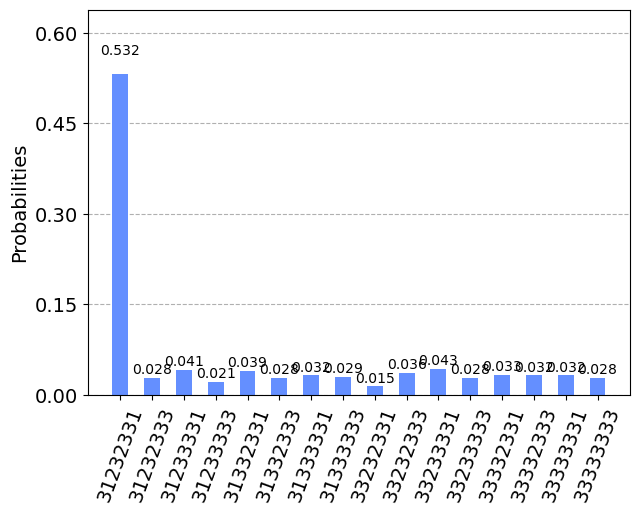

In [14]:
# Converting to decimal, 1-4 (since this is a 4x4 matrix)
def convert_to_decimal(str_bin):
    str_bin = ''.join(list(reversed(str_bin)))  # cbitに格納されるときに順番逆になっていることに注意
    list_dec = [str(int(str_bin[2*i:2*i+2], 2)+1) for i in range(len(str_bin)//2)]
    str_dec = ''.join(list_dec)
    return str_dec
# histogram plot (decimal representation)
count_decimal = {}
for key, value in count.items():
    count_decimal[convert_to_decimal(key)] = value
print(count_decimal)
plot_histogram(count_decimal)

In [15]:
def replace_matrix_vals(matrix):
    new_matrix = []
    replace_idx = 0
    #first sol from above
    replacements = [int(x) for x in str(convert_to_decimal(next(iter(count.items()))[0]))]
    for list in matrix:
        for num in list:
            if num == 0:
                new_matrix.append(replacements[replace_idx])
                replace_idx+=1
            else:
                new_matrix.append(num)
    return np.array(new_matrix).reshape(4,4)

filled_sudoku = replace_matrix_vals(matrix)
print(filled_sudoku)

[[4 3 2 1]
 [2 1 3 4]
 [1 2 4 3]
 [3 4 1 2]]
